## U-Net

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import autograd, optim
from torchvision.transforms import transforms
import torch.nn as nn
import torch.utils.data as data
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
# 读取数据的路径
def make_dataset(root):
    imgs = []
    # 计算共有多少张原始图片
    n = len(os.listdir(root))//2
    for i in range(n):
        # 找到00i.png的路径
        img = os.path.join(root, '%03d.png'%i)
        # 找到00i_mask.png的路径
        mask = os.path.join(root, '%03d_mask.png'%i)
        # 添加至列表
        imgs.append((img, mask))
    return imgs

In [3]:
class LiverDataset(data.Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y
    def __len__(self):
        return len(self.imgs)

In [4]:
x_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
# mask只需转为Tensor
y_transforms = transforms.ToTensor()

In [5]:
batch_size = 1
liver_dataset = LiverDataset('data/liver/train', transform=x_transforms, target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
# U_Net模型中的双卷积网络结构
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # 此处包含padding，为了使输出图像与输入图像大小相同
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True)
        )
    def forward(self, input):
        return self.conv(input)

In [7]:
class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        # 特征图大小不变
        self.conv1 = DoubleConv(in_ch, 64)
        # 特征图大小长宽减半
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        # 长宽翻倍，通道数减半
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, out_ch, 1)
        
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        # 通道维拼接
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return out

In [8]:
# 输入图像有3个通道，标签图像有1个通道
net = Unet(3, 1).to(device)
loss = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [9]:
def train_model(model, loss, optimizer, dataloaders, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        dt_size = len(dataloaders.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataloaders:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            l = loss(outputs, labels)
            l.backward()
            optimizer.step()
            epoch_loss += l.item()
            if step % 200 == 0:
                print('%d/%d, train_loss:%0.3f' % (step, (dt_size-1)//dataloaders.batch_size+1, l.item()))
        print('epoch %d loss:%0.3f' % (epoch, epoch_loss))
    return model

In [10]:
model = train_model(net, loss, optimizer, dataloaders)

Epoch 0/19
----------
200/400, train_loss:0.094
400/400, train_loss:0.036
epoch 0 loss:51.922
Epoch 1/19
----------
200/400, train_loss:0.030
400/400, train_loss:0.024
epoch 1 loss:9.863
Epoch 2/19
----------
200/400, train_loss:0.017
400/400, train_loss:0.017
epoch 2 loss:6.595
Epoch 3/19
----------
200/400, train_loss:0.012
400/400, train_loss:0.017
epoch 3 loss:6.298
Epoch 4/19
----------
200/400, train_loss:0.016
400/400, train_loss:0.007
epoch 4 loss:4.670
Epoch 5/19
----------
200/400, train_loss:0.006
400/400, train_loss:0.007
epoch 5 loss:3.355
Epoch 6/19
----------
200/400, train_loss:0.003
400/400, train_loss:0.002
epoch 6 loss:3.105
Epoch 7/19
----------
200/400, train_loss:0.006
400/400, train_loss:0.010
epoch 7 loss:2.769
Epoch 8/19
----------
200/400, train_loss:0.007
400/400, train_loss:0.008
epoch 8 loss:2.685
Epoch 9/19
----------
200/400, train_loss:0.009
400/400, train_loss:0.006
epoch 9 loss:2.760
Epoch 10/19
----------
200/400, train_loss:0.008
400/400, train_loss:

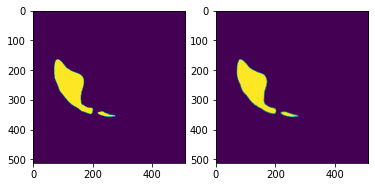

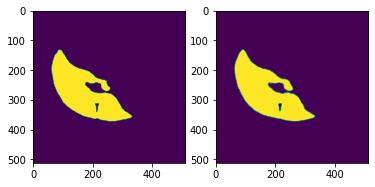

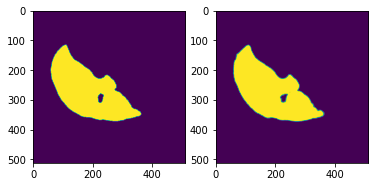

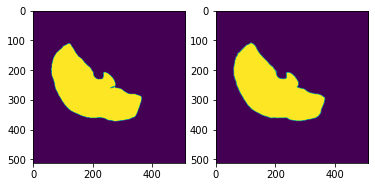

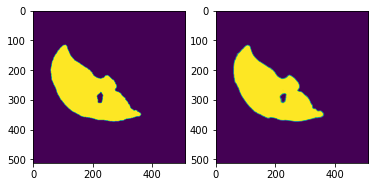

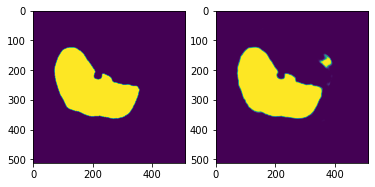

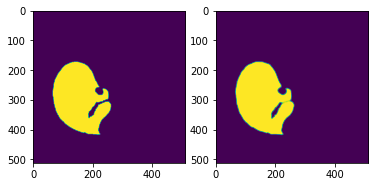

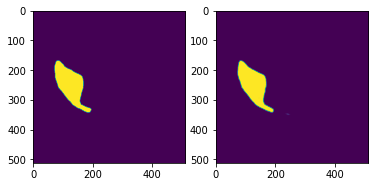

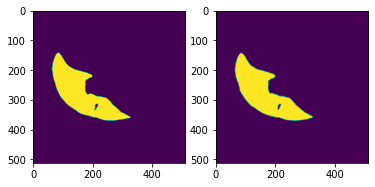

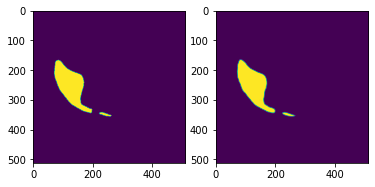

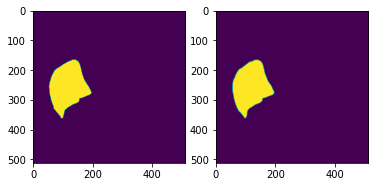

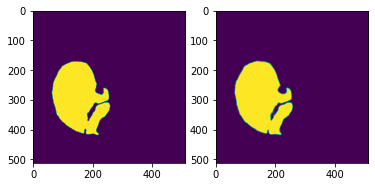

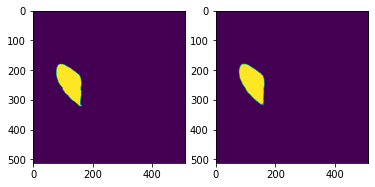

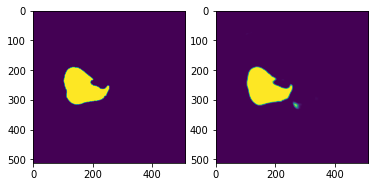

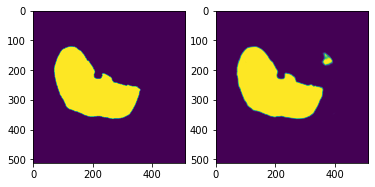

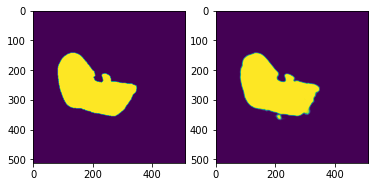

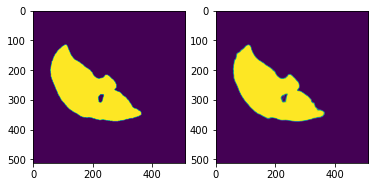

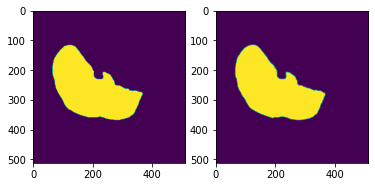

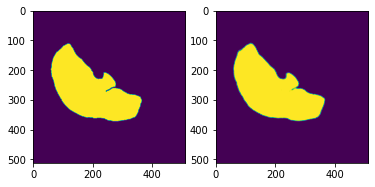

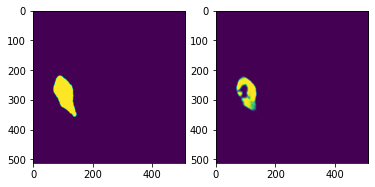

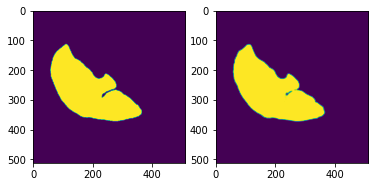

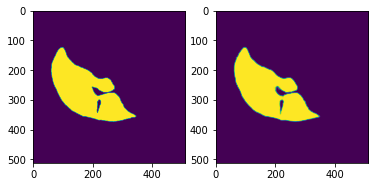

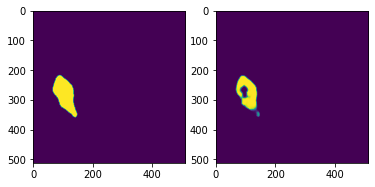

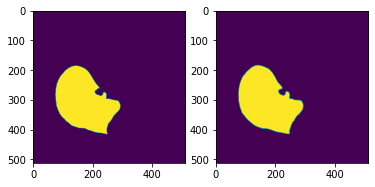

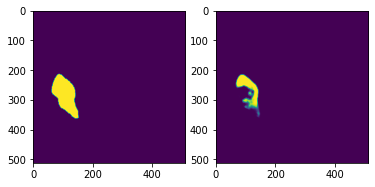

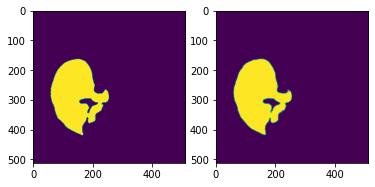

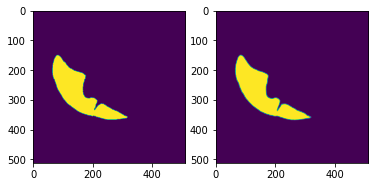

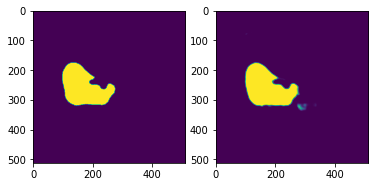

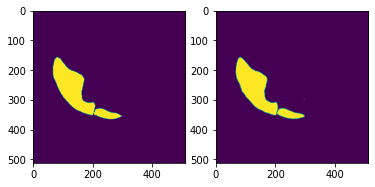

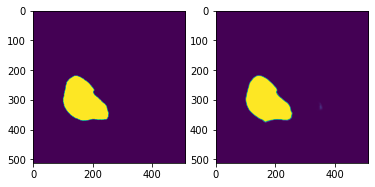

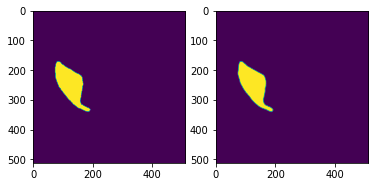

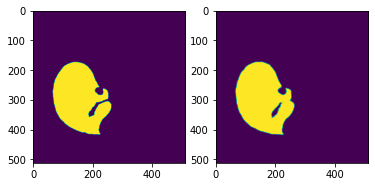

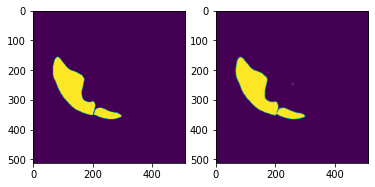

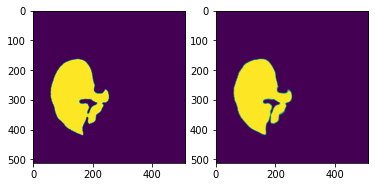

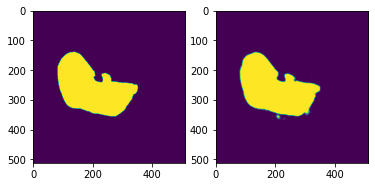

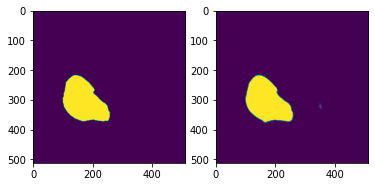

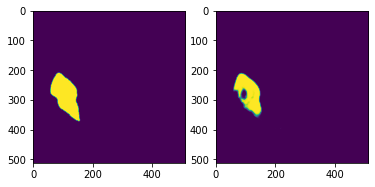

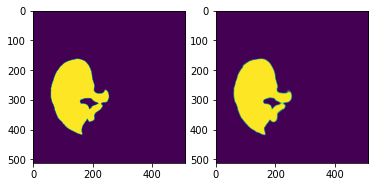

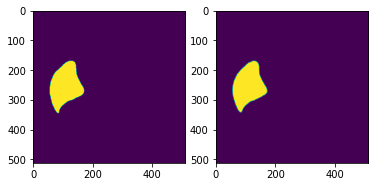

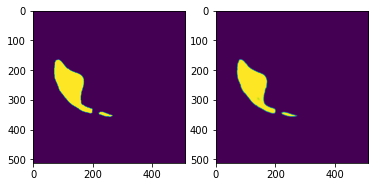

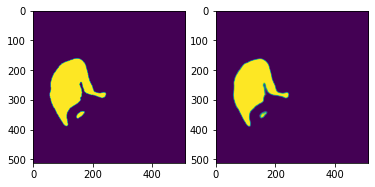

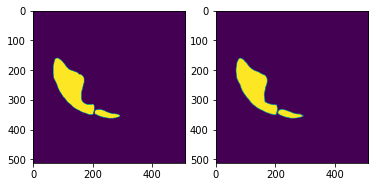

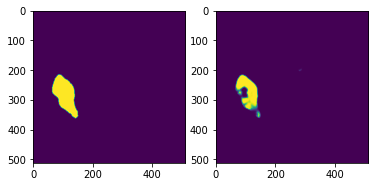

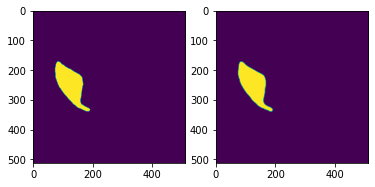

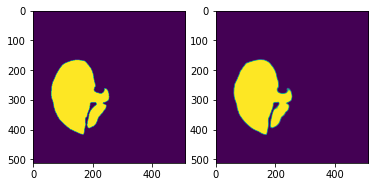

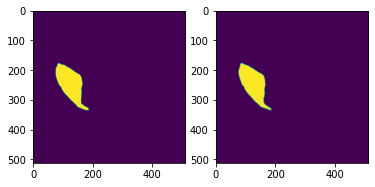

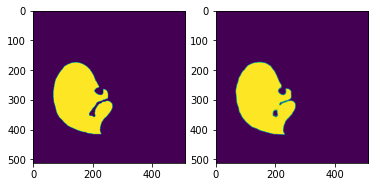

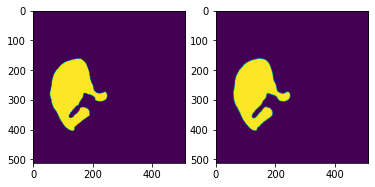

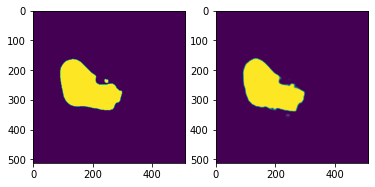

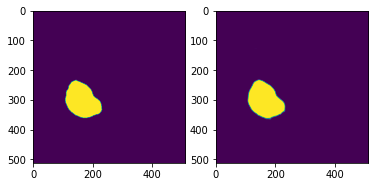

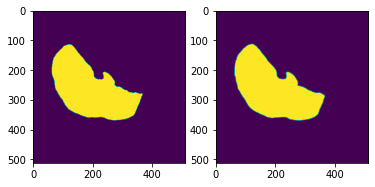

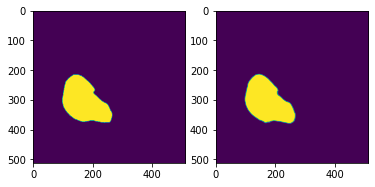

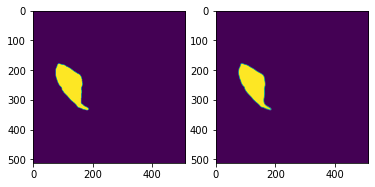

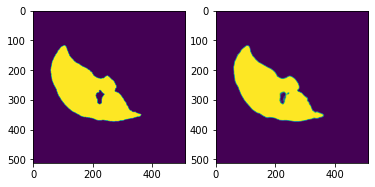

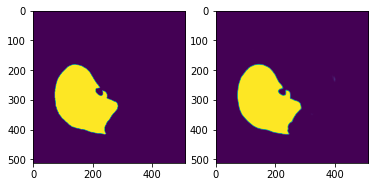

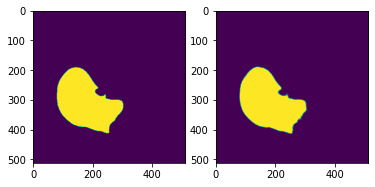

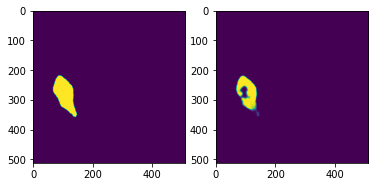

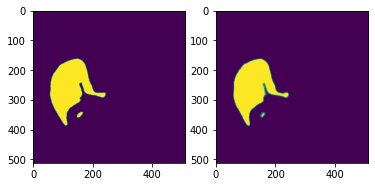

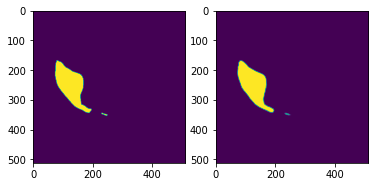

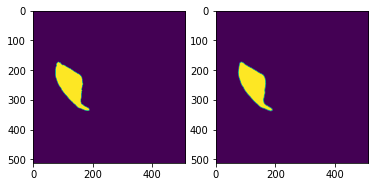

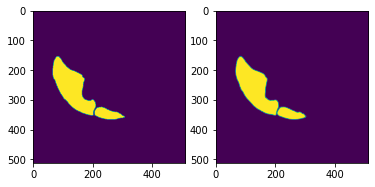

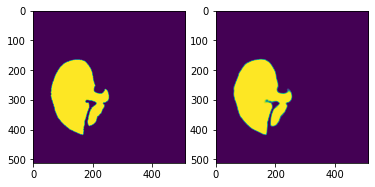

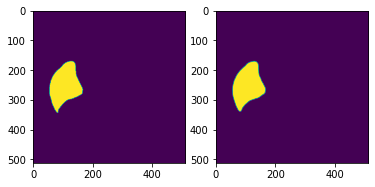

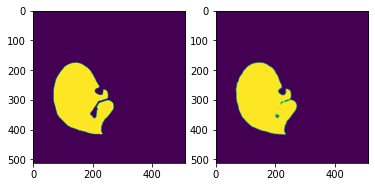

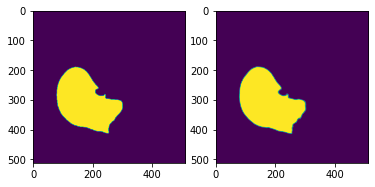

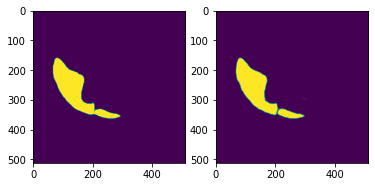

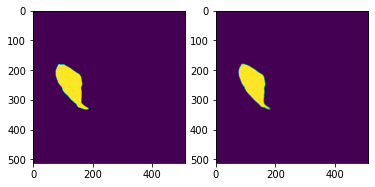

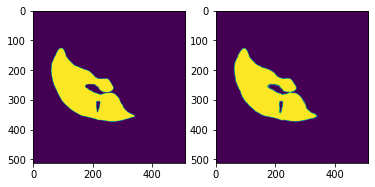

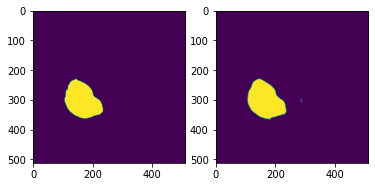

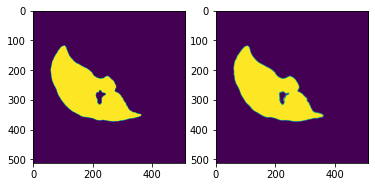

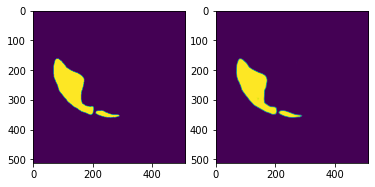

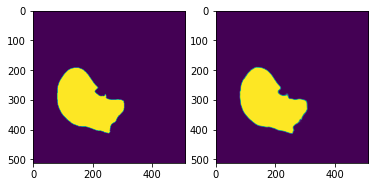

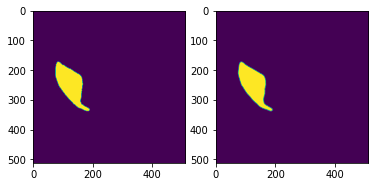

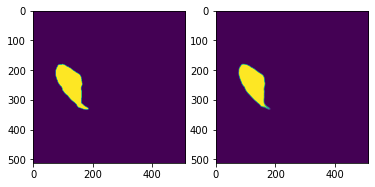

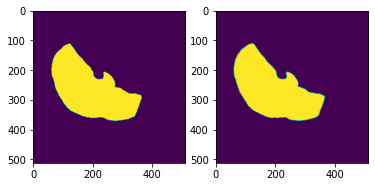

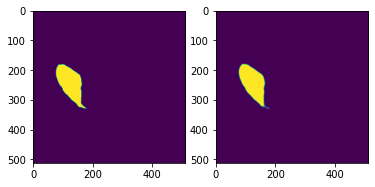

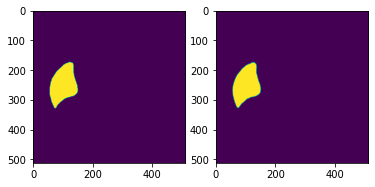

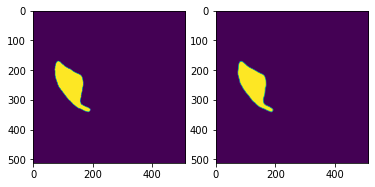

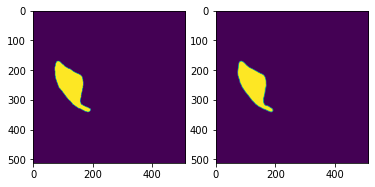

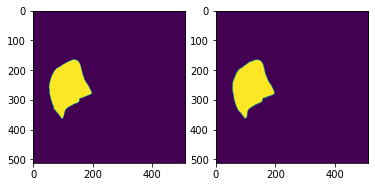

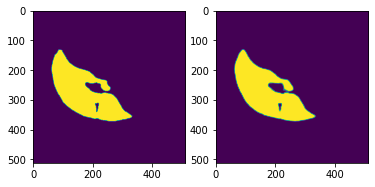

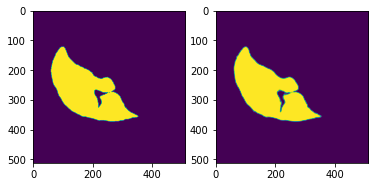

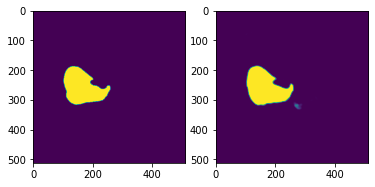

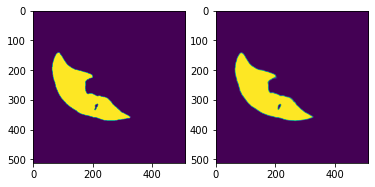

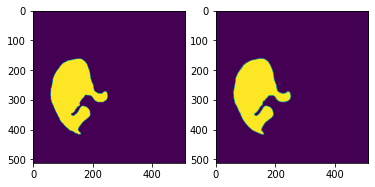

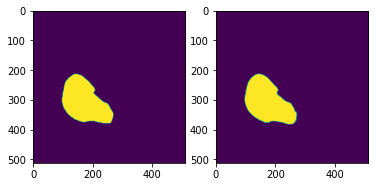

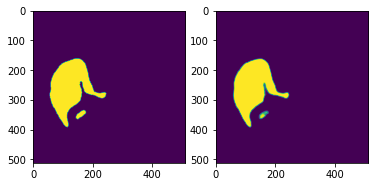

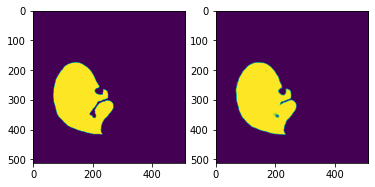

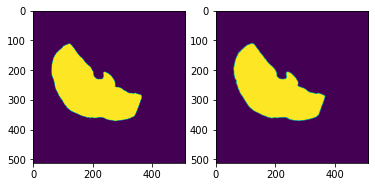

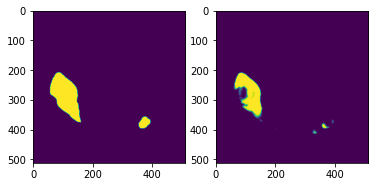

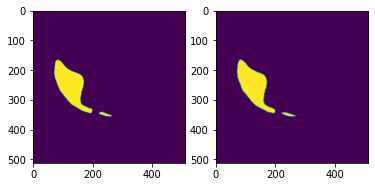

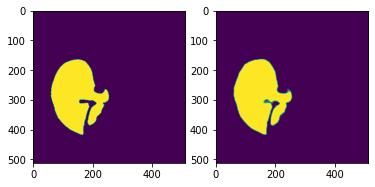

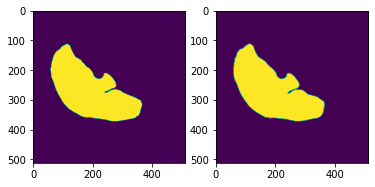

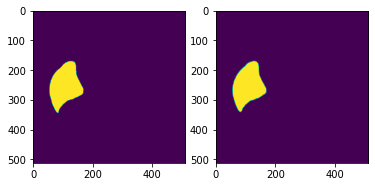

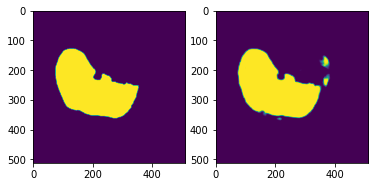

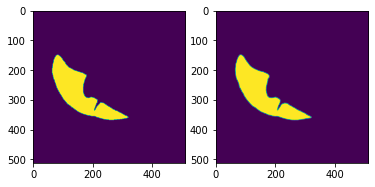

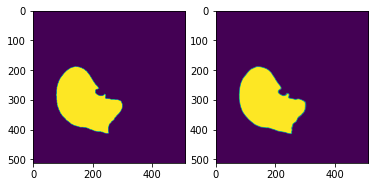

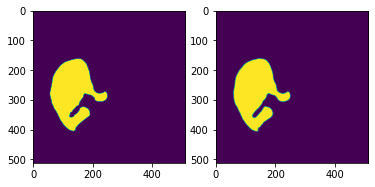

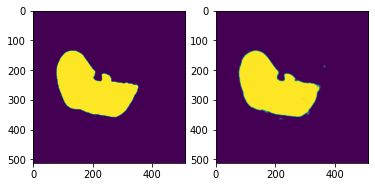

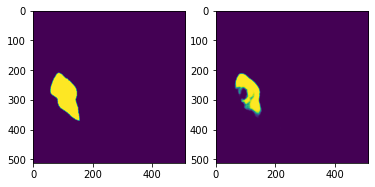

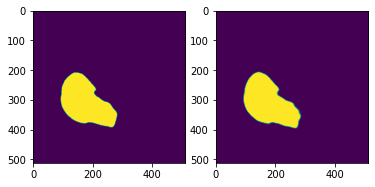

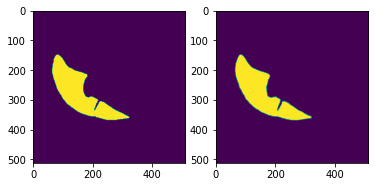

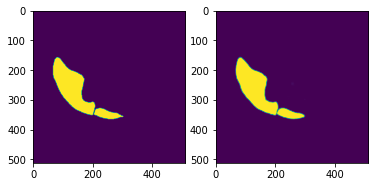

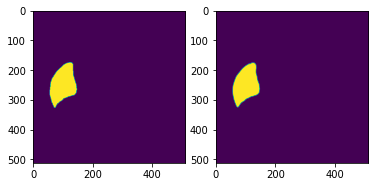

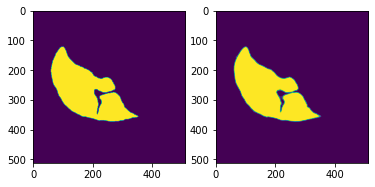

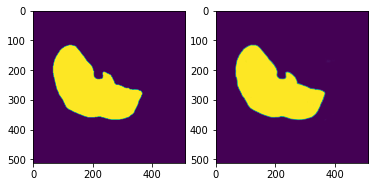

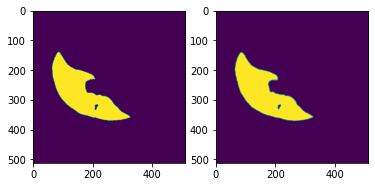

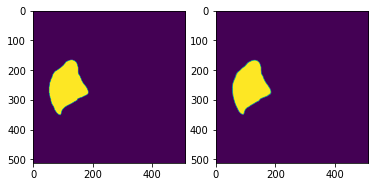

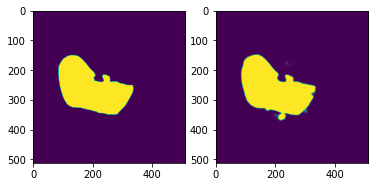

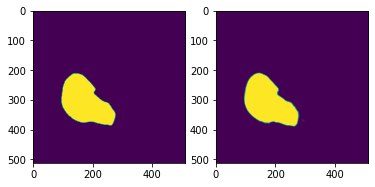

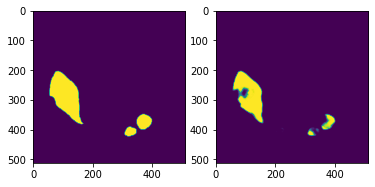

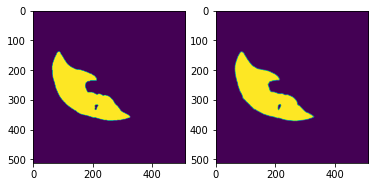

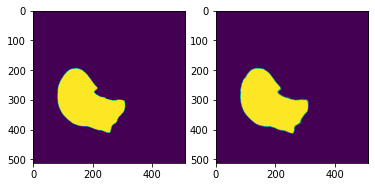

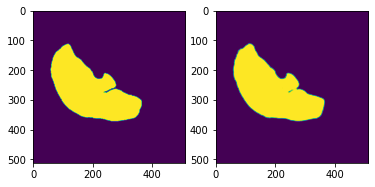

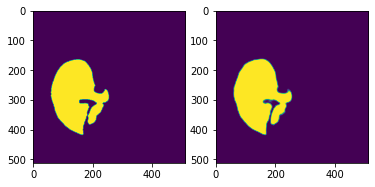

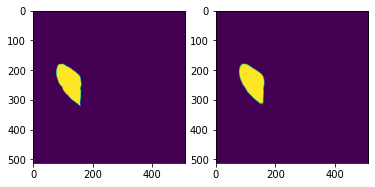

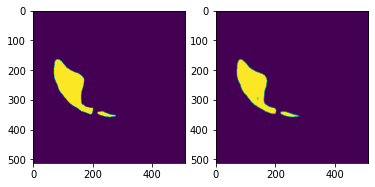

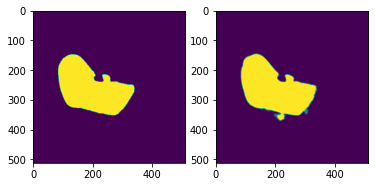

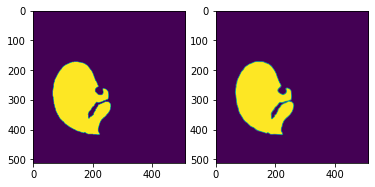

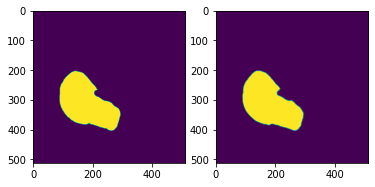

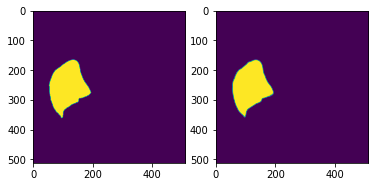

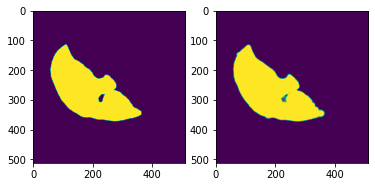

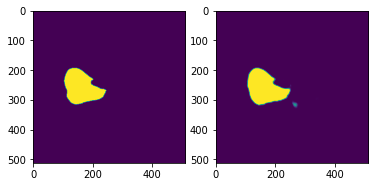

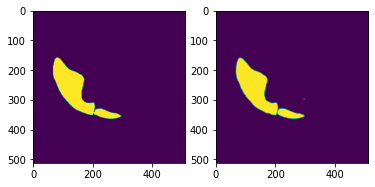

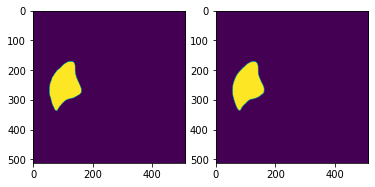

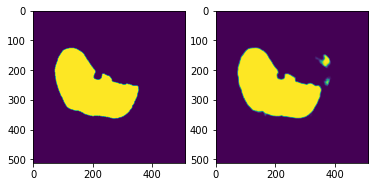

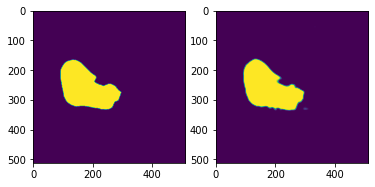

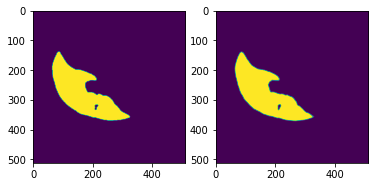

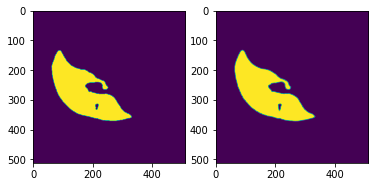

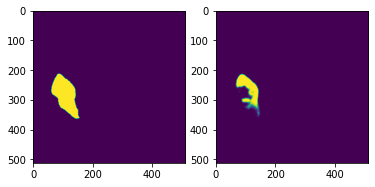

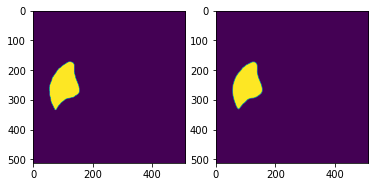

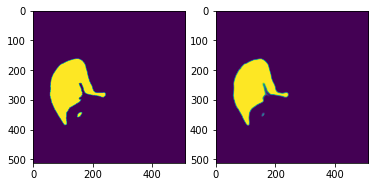

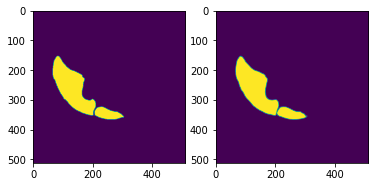

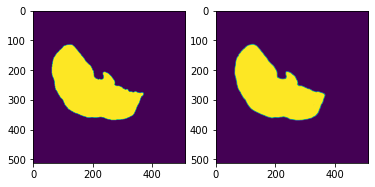

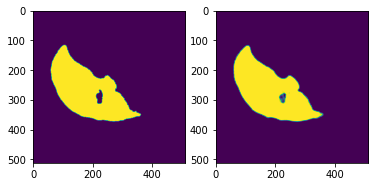

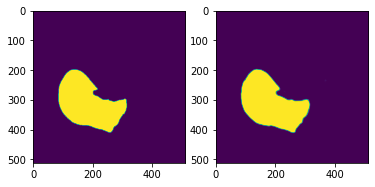

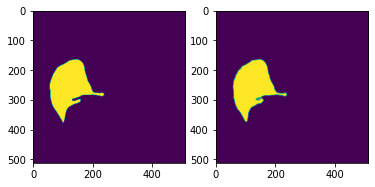

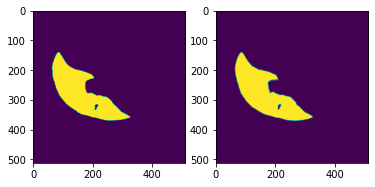

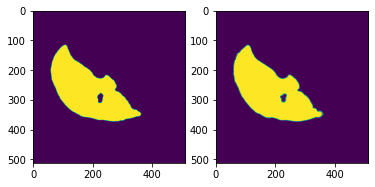

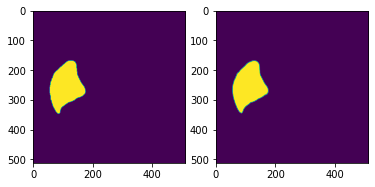

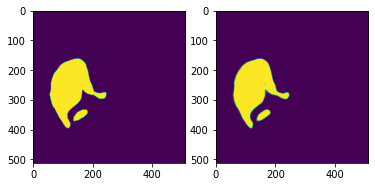

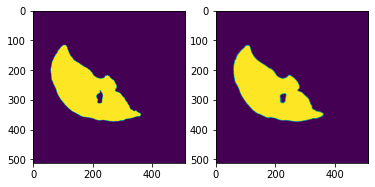

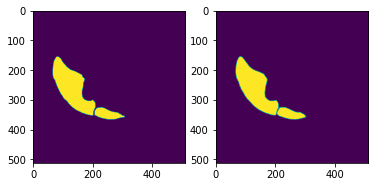

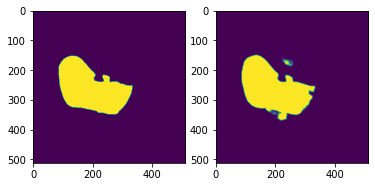

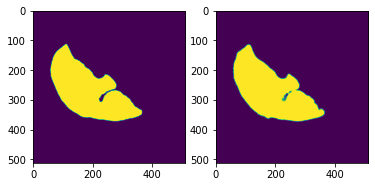

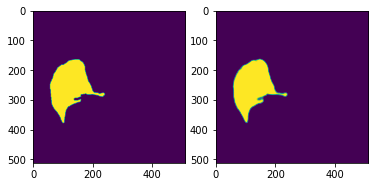

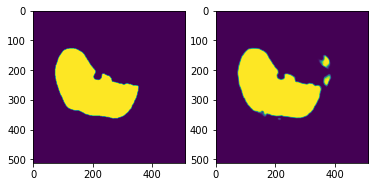

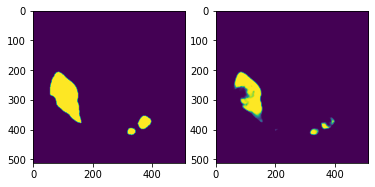

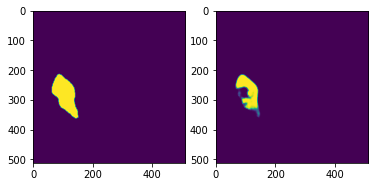

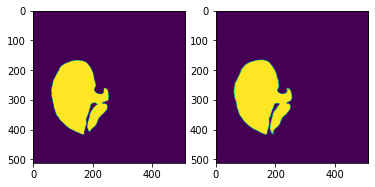

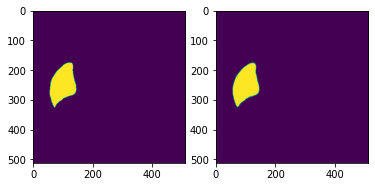

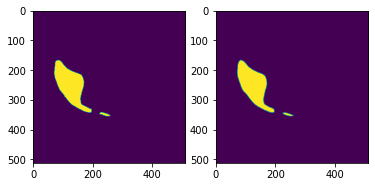

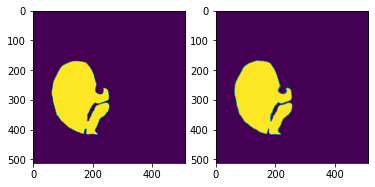

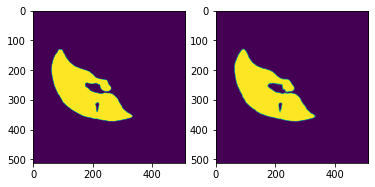

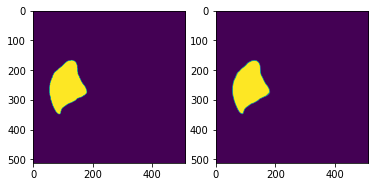

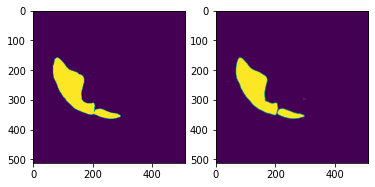

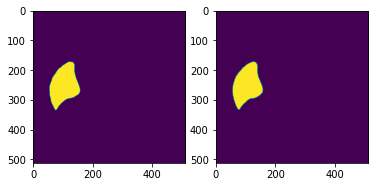

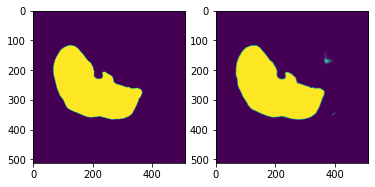

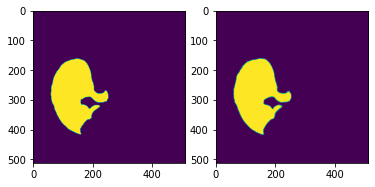

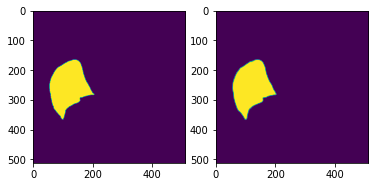

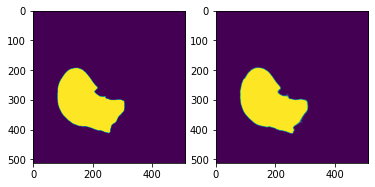

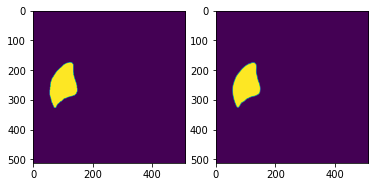

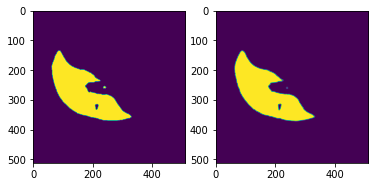

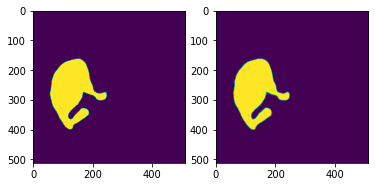

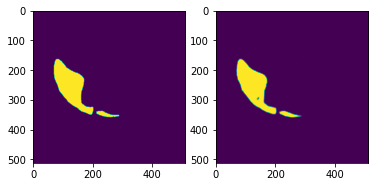

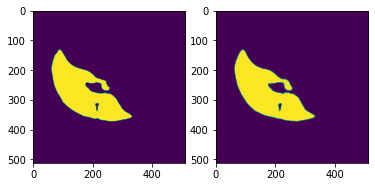

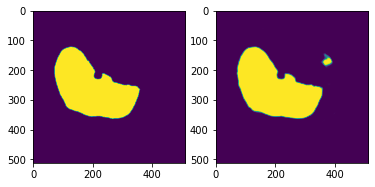

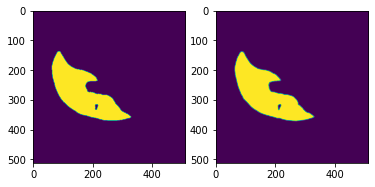

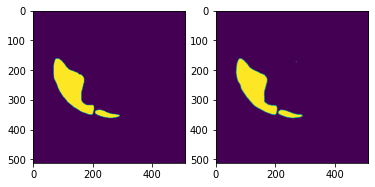

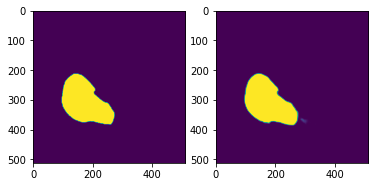

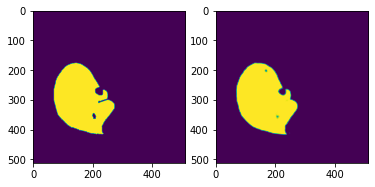

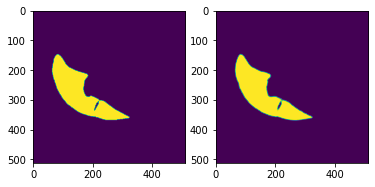

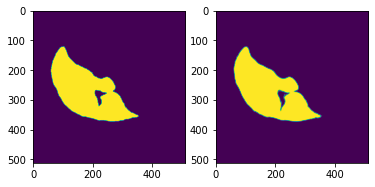

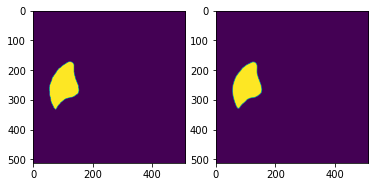

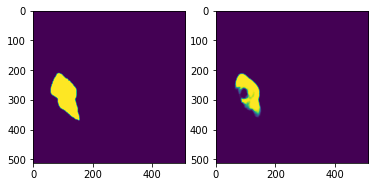

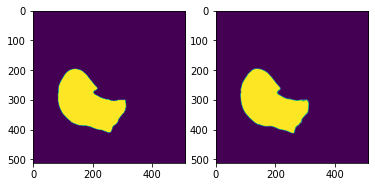

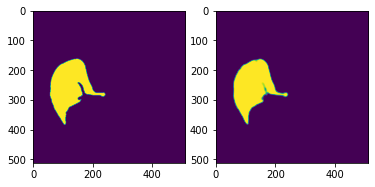

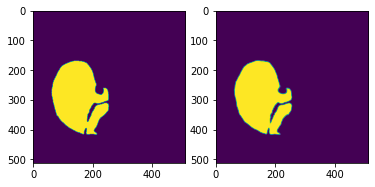

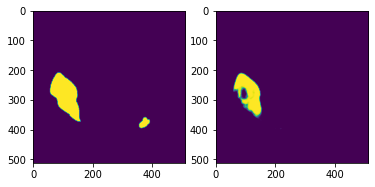

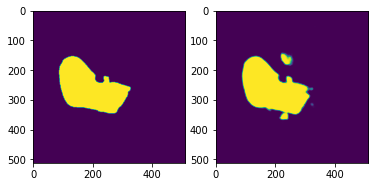

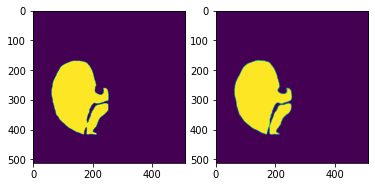

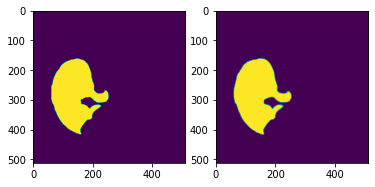

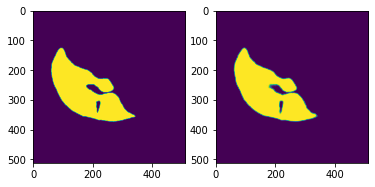

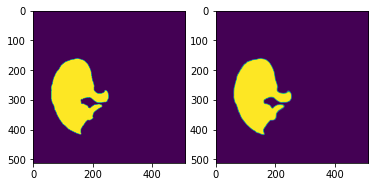

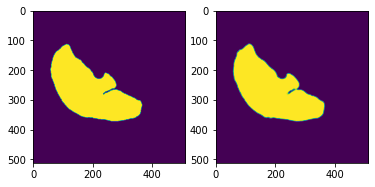

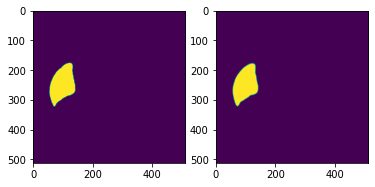

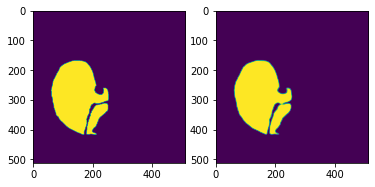

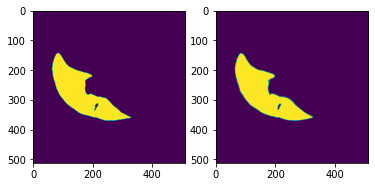

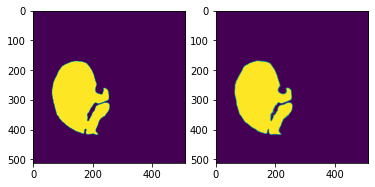

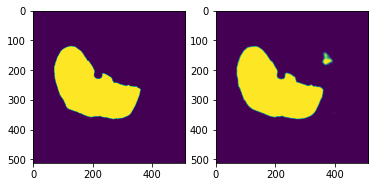

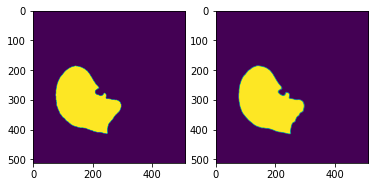

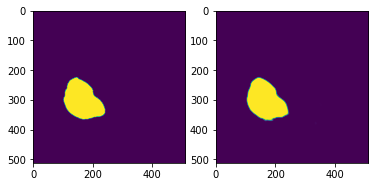

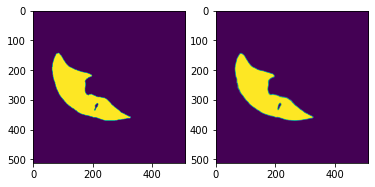

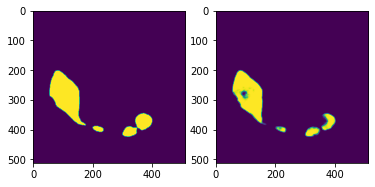

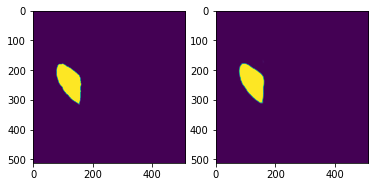

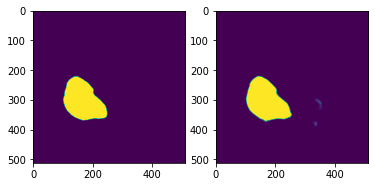

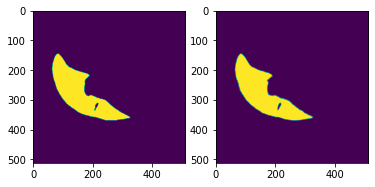

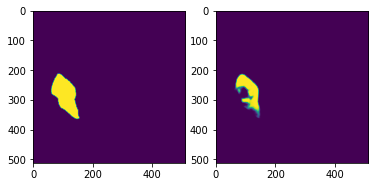

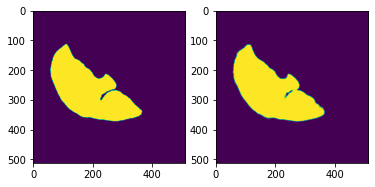

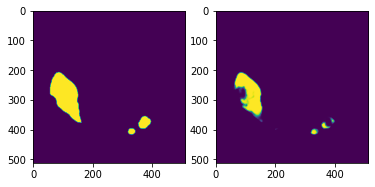

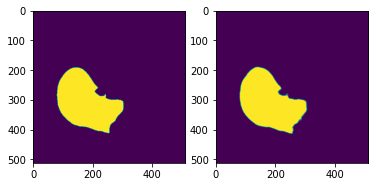

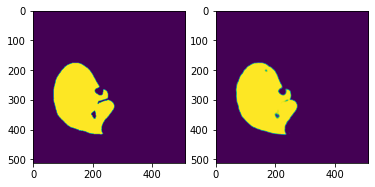

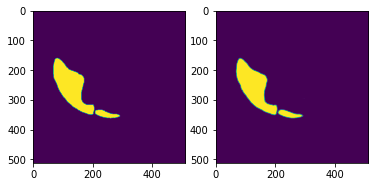

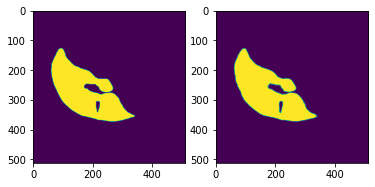

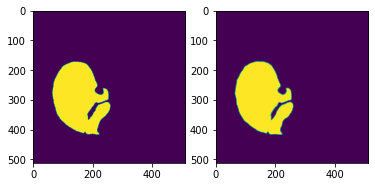

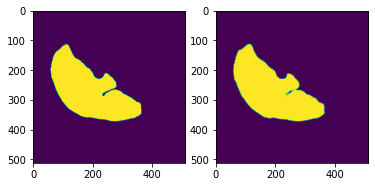

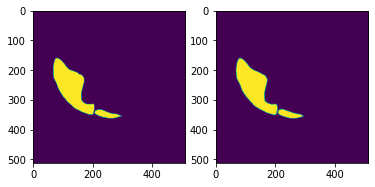

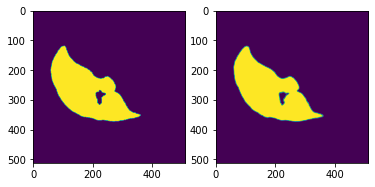

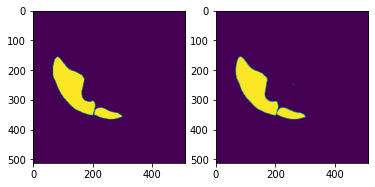

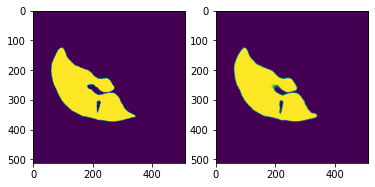

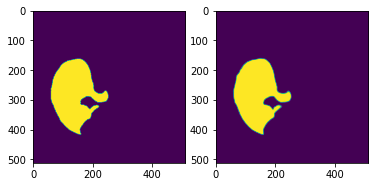

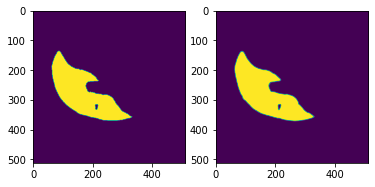

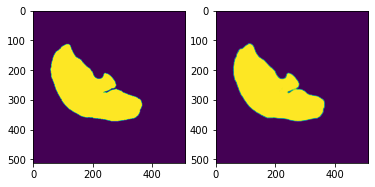

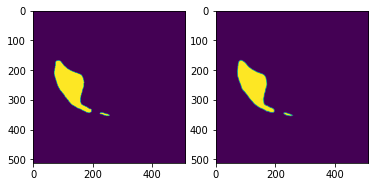

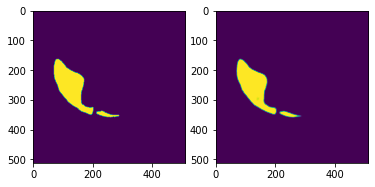

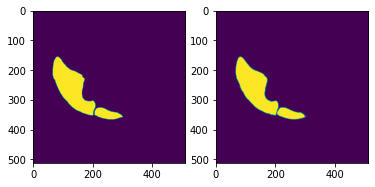

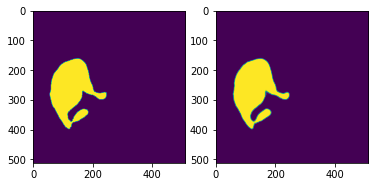

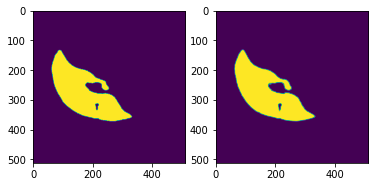

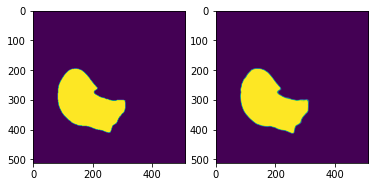

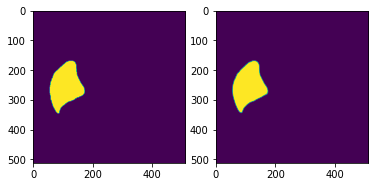

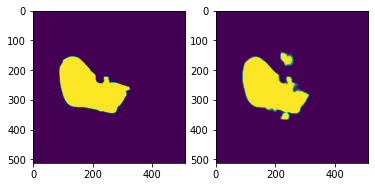

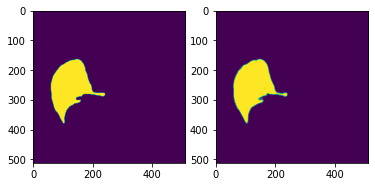

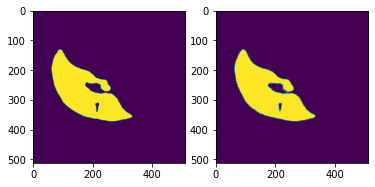

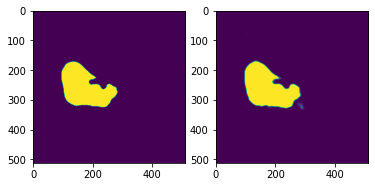

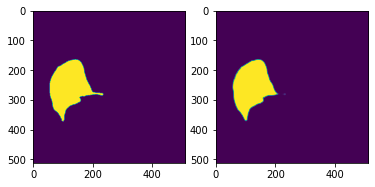

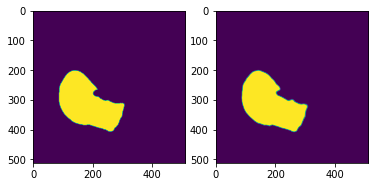

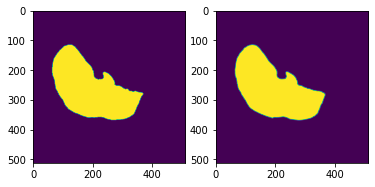

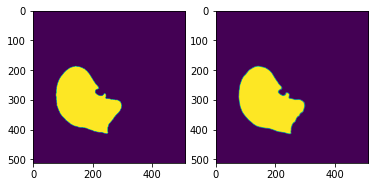

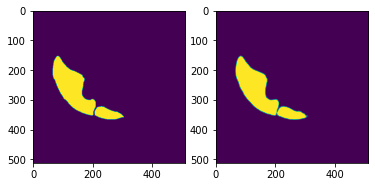

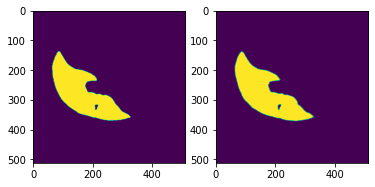

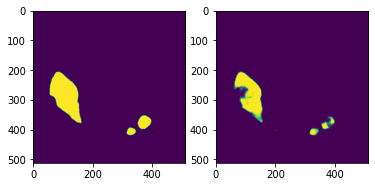

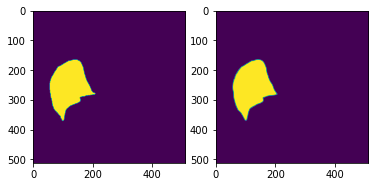

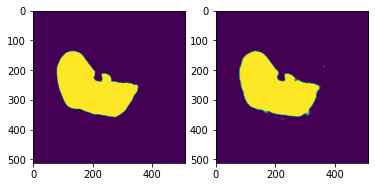

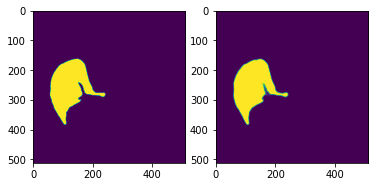

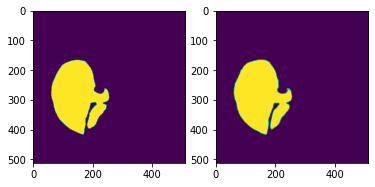

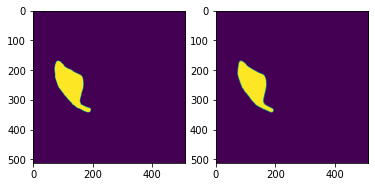

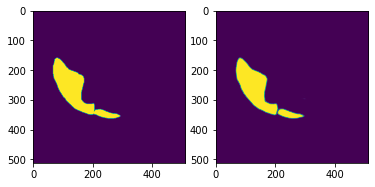

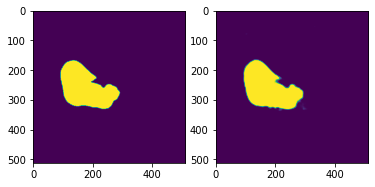

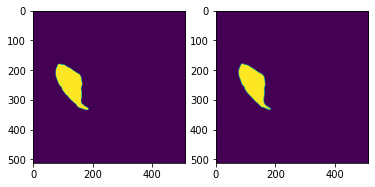

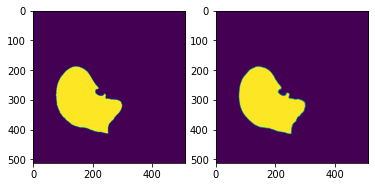

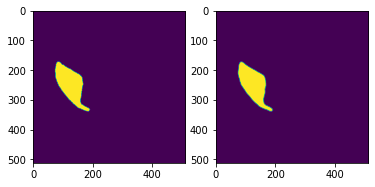

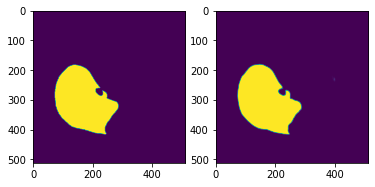

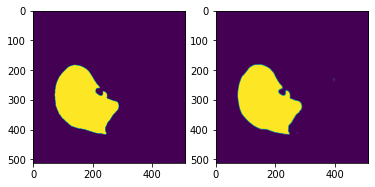

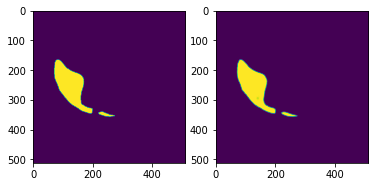

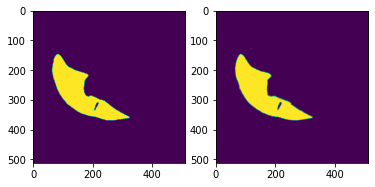

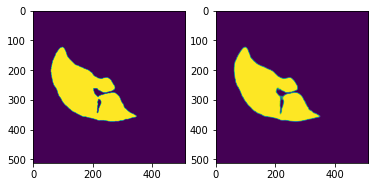

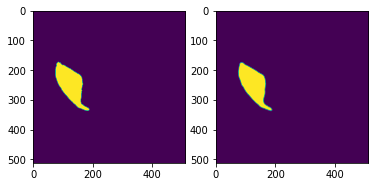

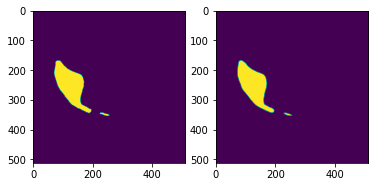

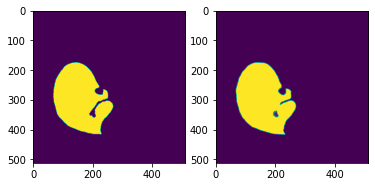

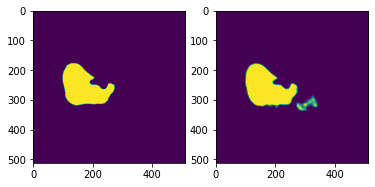

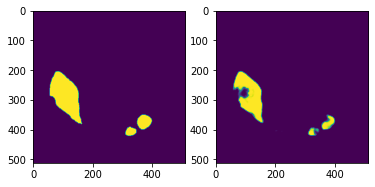

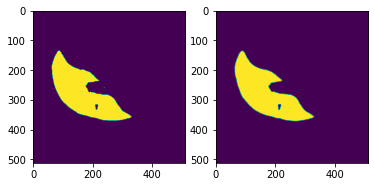

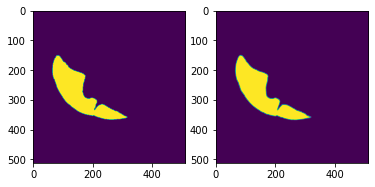

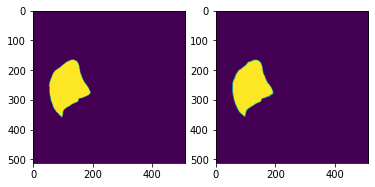

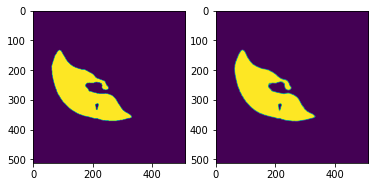

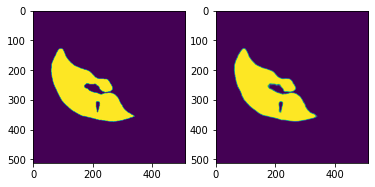

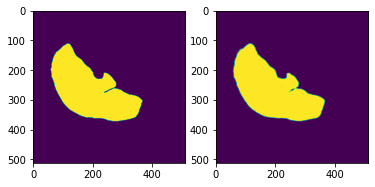

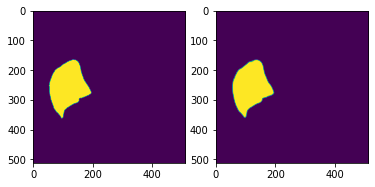

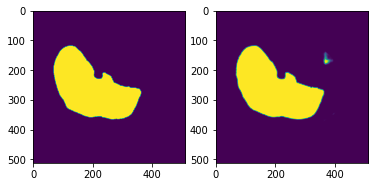

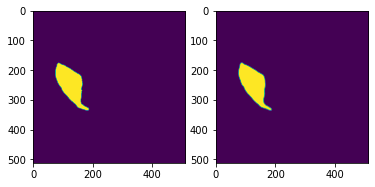

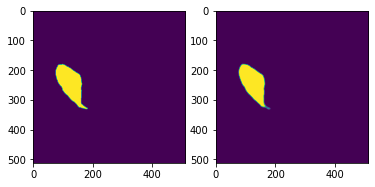

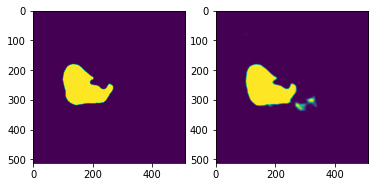

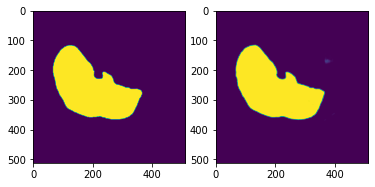

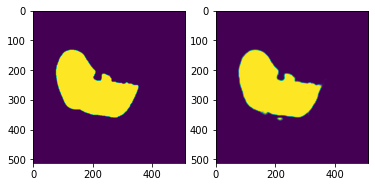

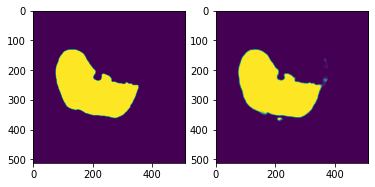

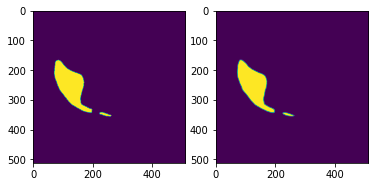

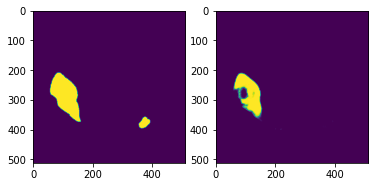

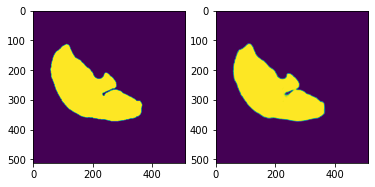

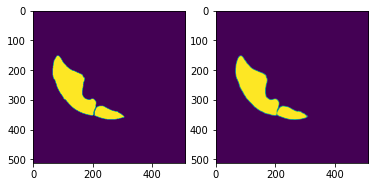

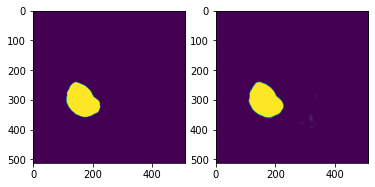

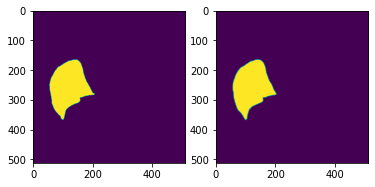

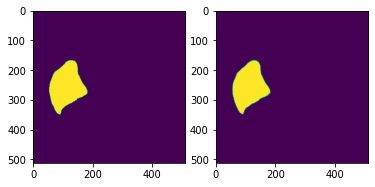

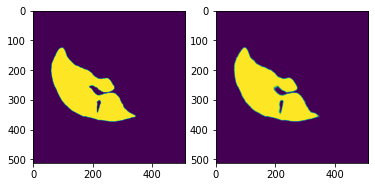

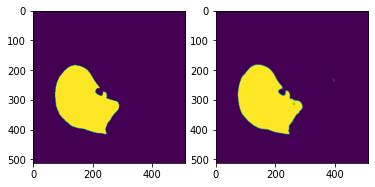

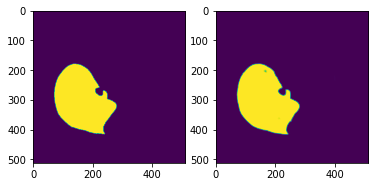

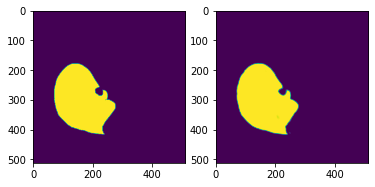

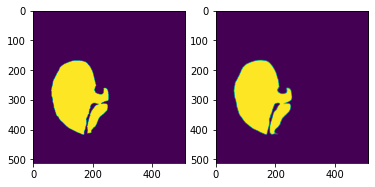

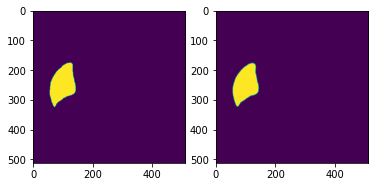

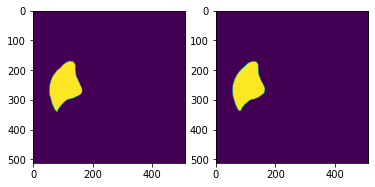

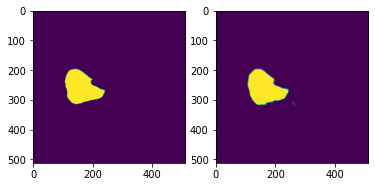

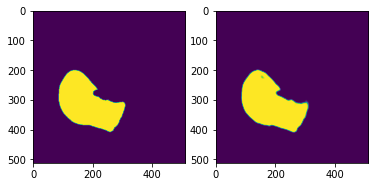

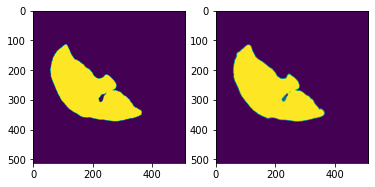

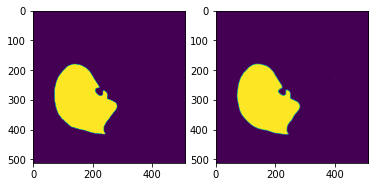

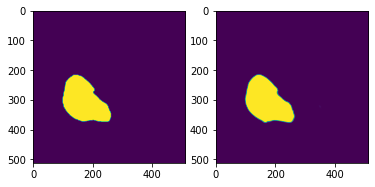

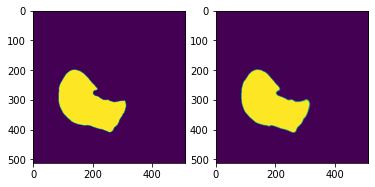

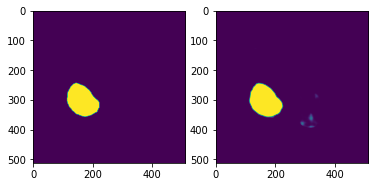

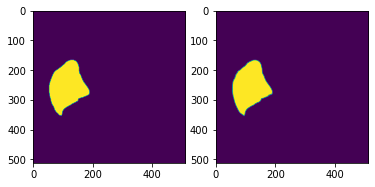

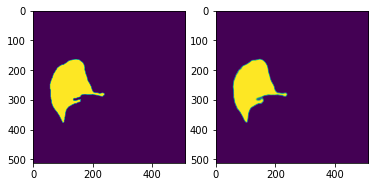

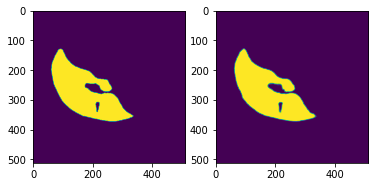

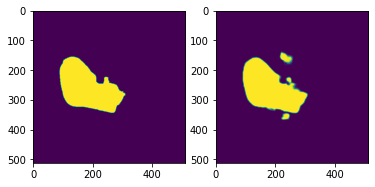

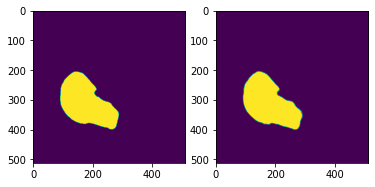

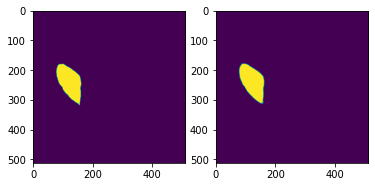

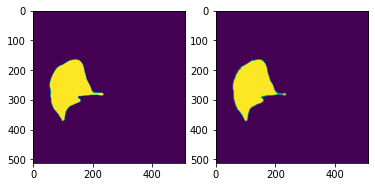

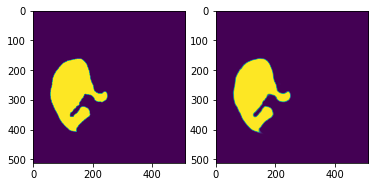

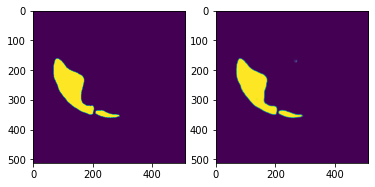

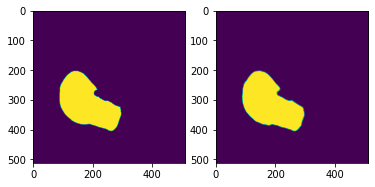

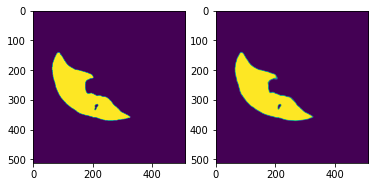

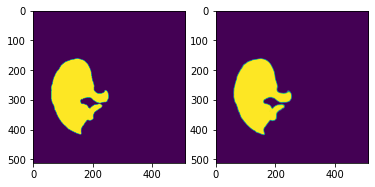

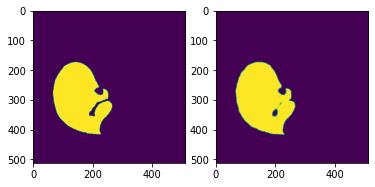

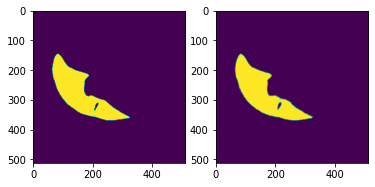

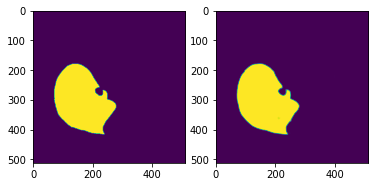

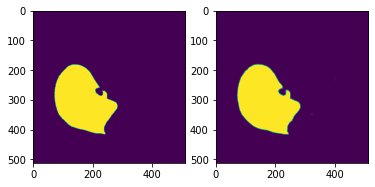

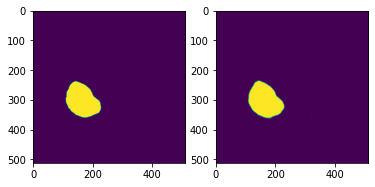

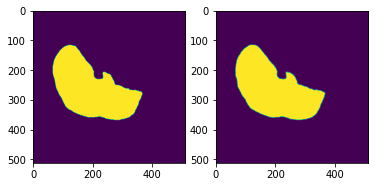

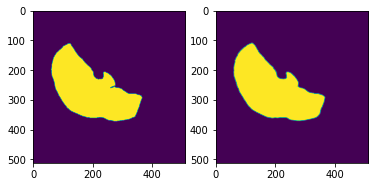

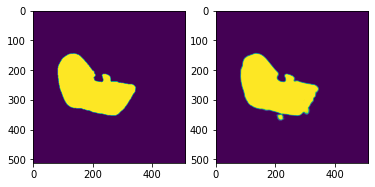

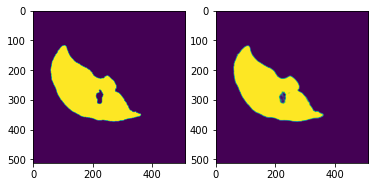

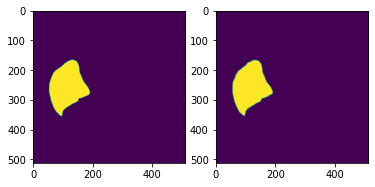

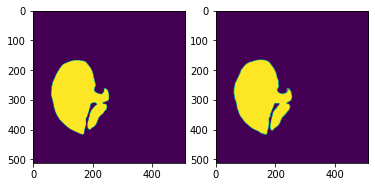

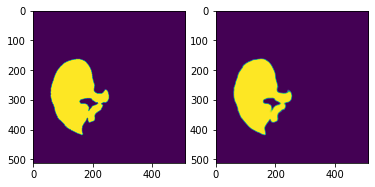

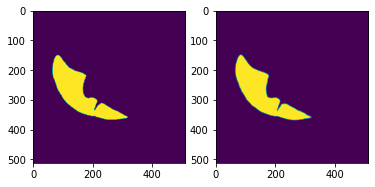

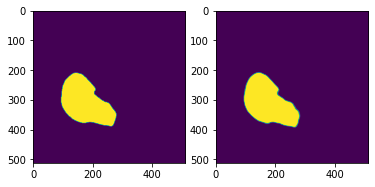

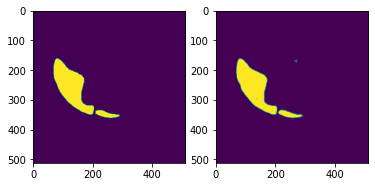

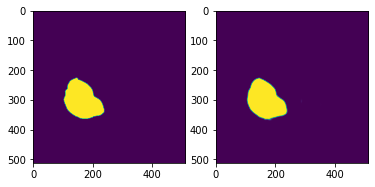

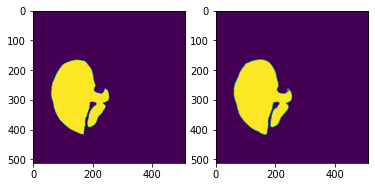

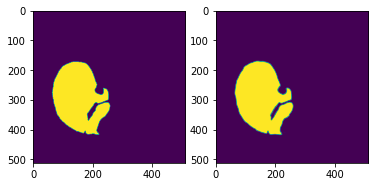

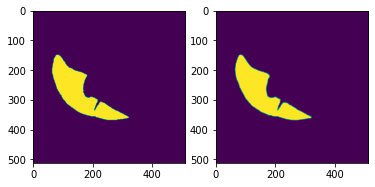

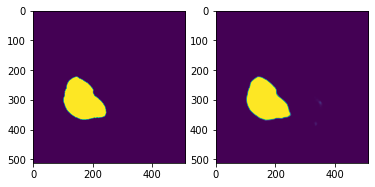

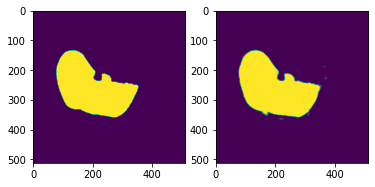

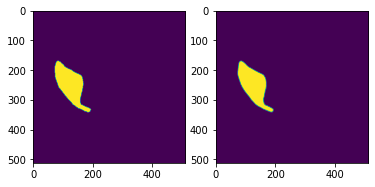

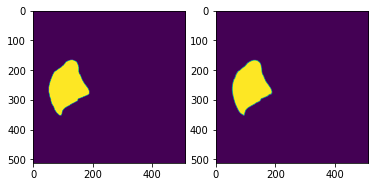

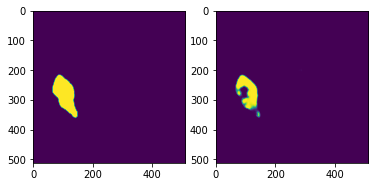

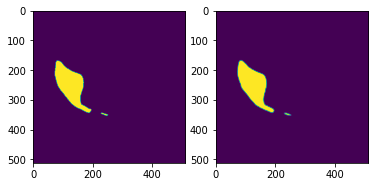

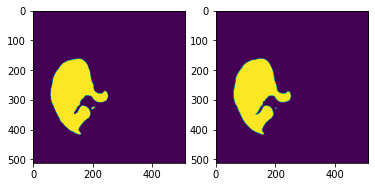

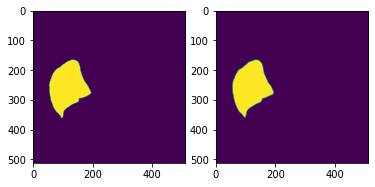

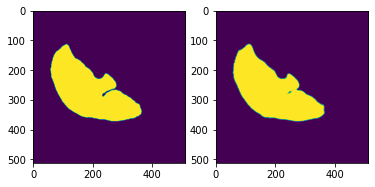

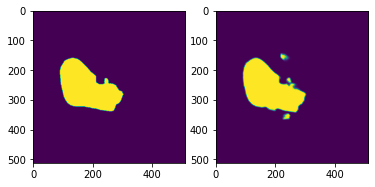

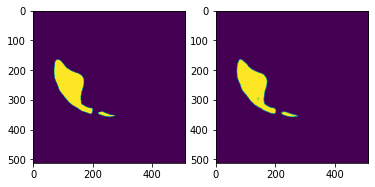

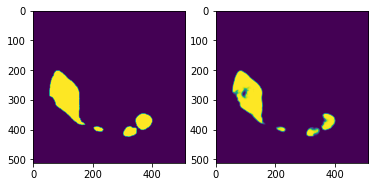

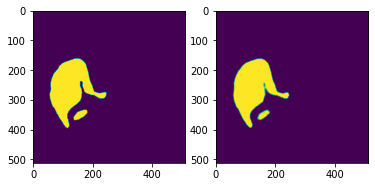

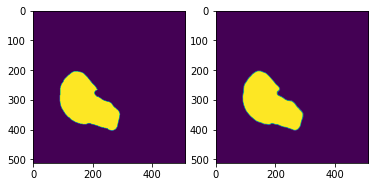

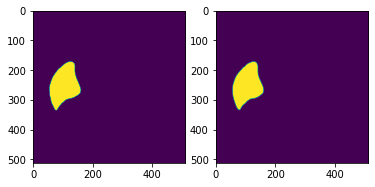

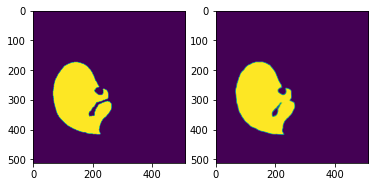

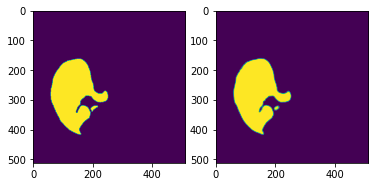

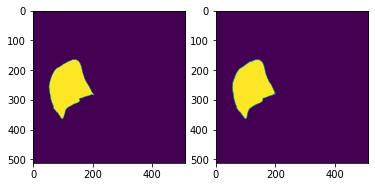

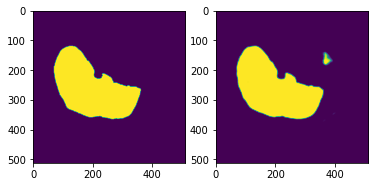

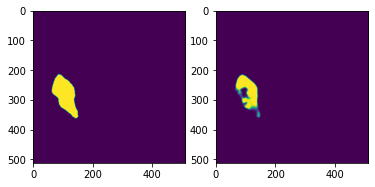

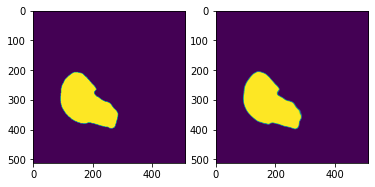

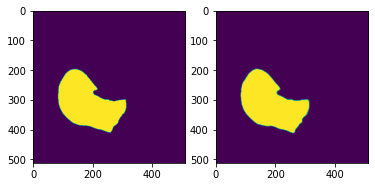

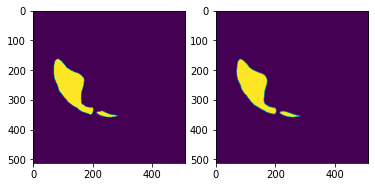

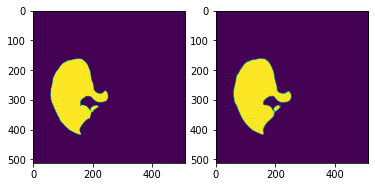

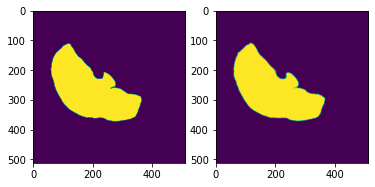

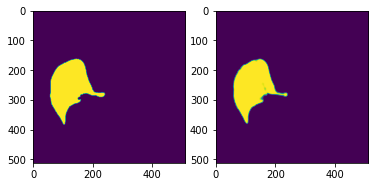

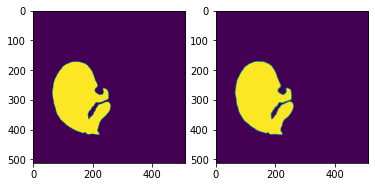

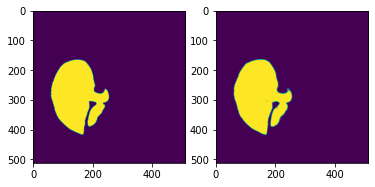

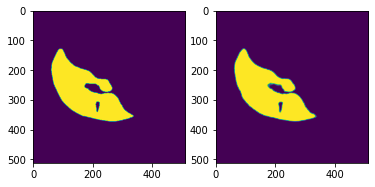

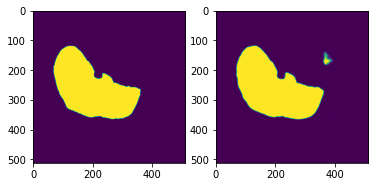

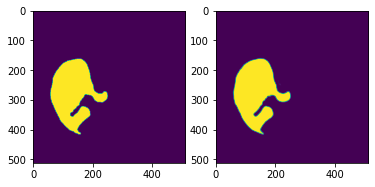

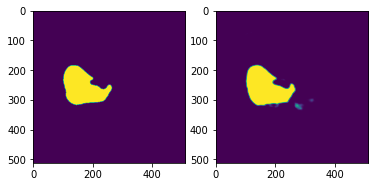

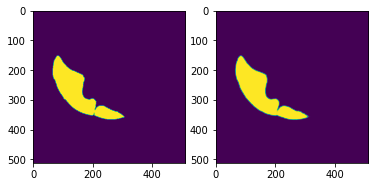

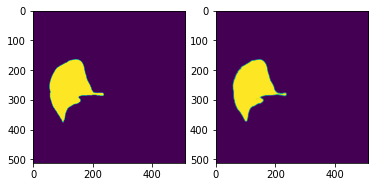

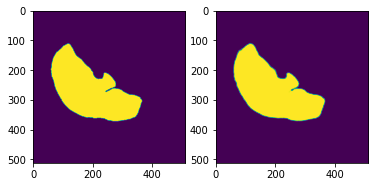

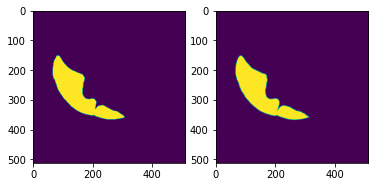

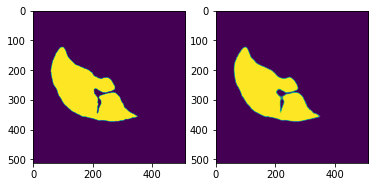

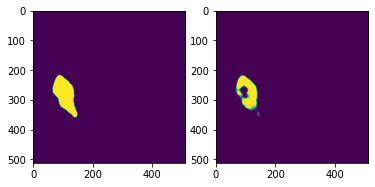

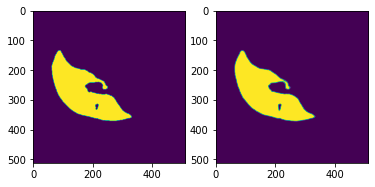

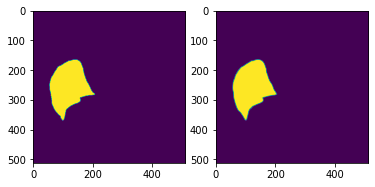

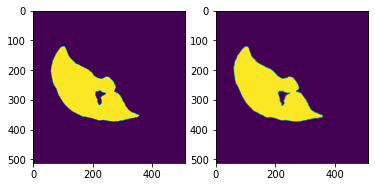

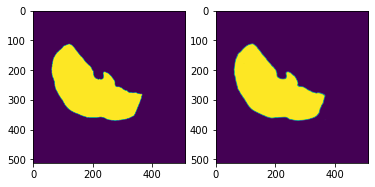

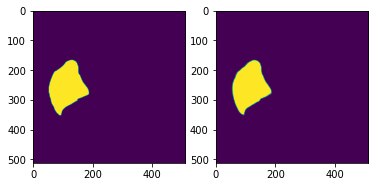

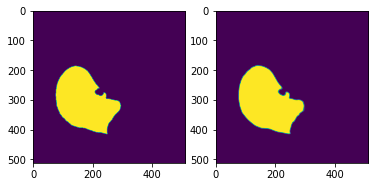

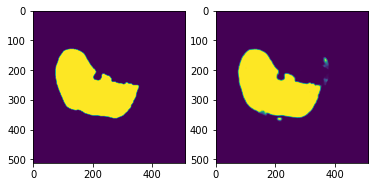

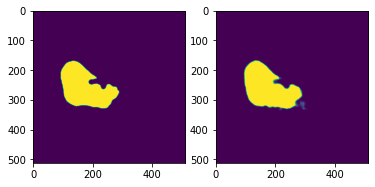

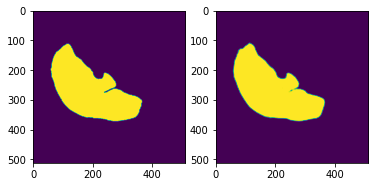

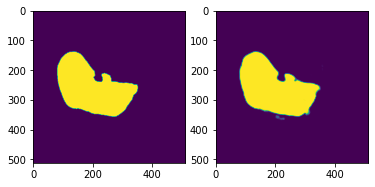

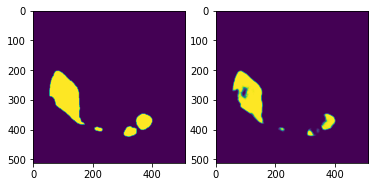

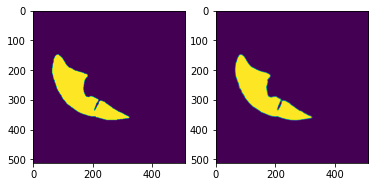

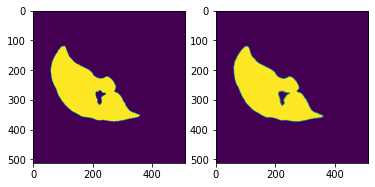

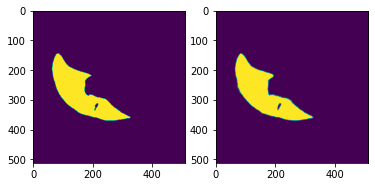

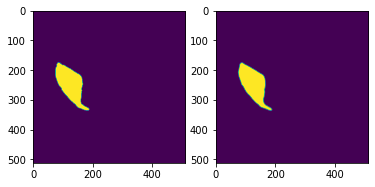

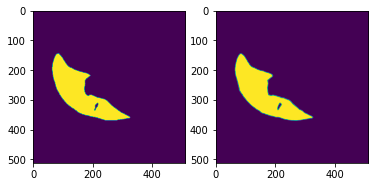

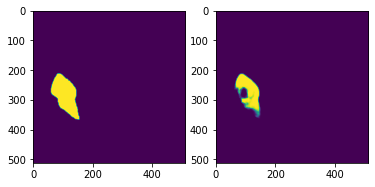

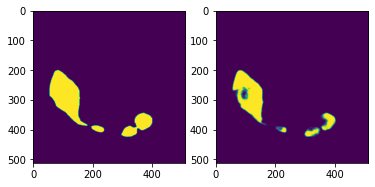

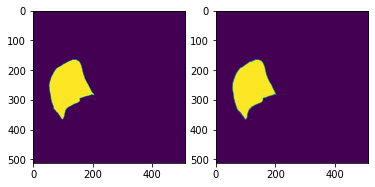

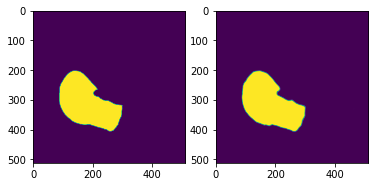

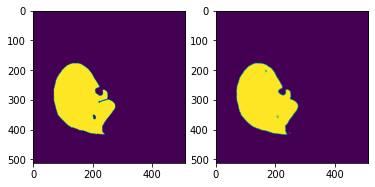

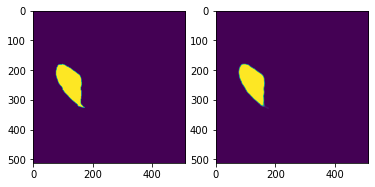

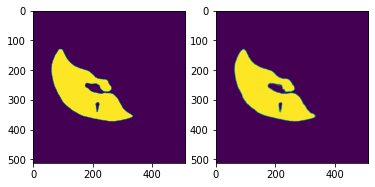

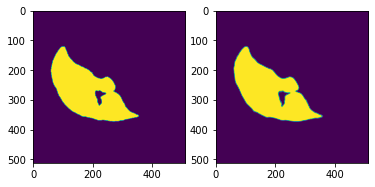

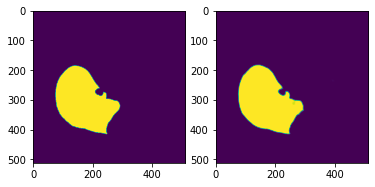

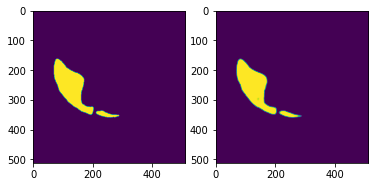

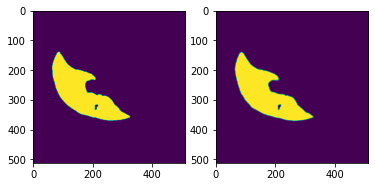

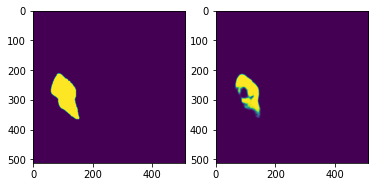

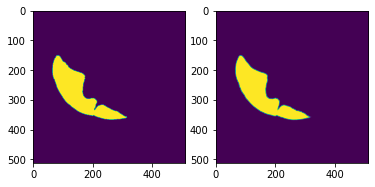

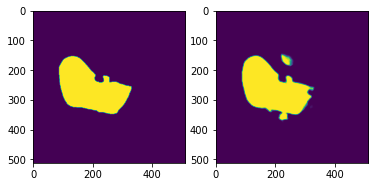

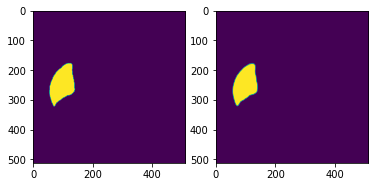

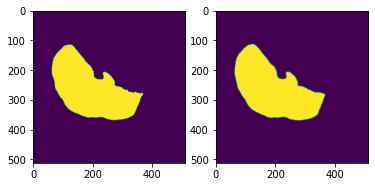

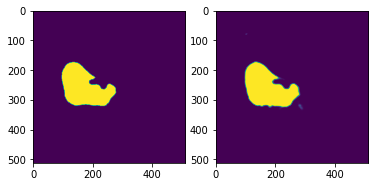

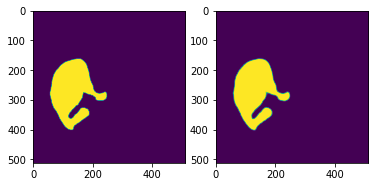

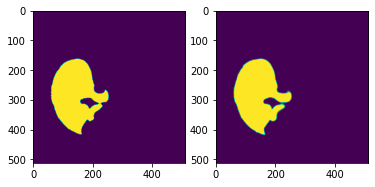

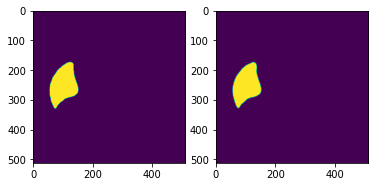

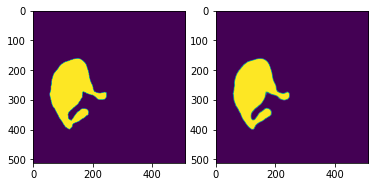

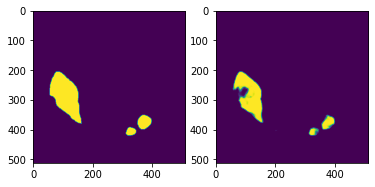

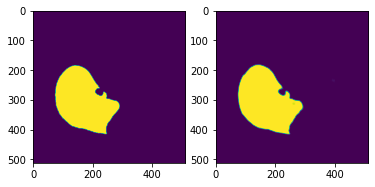

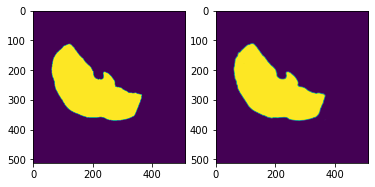

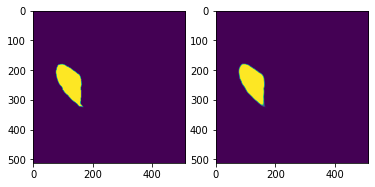

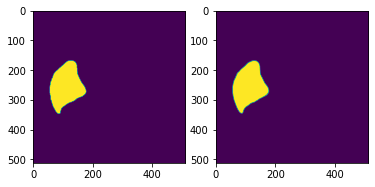

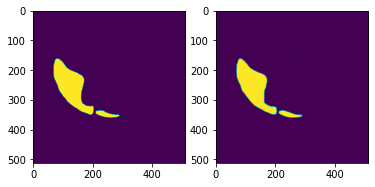

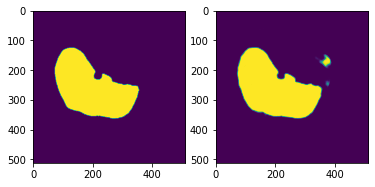

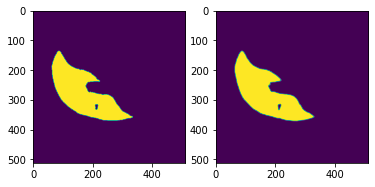

In [21]:
liver_val = LiverDataset('data/liver/val', transform=x_transforms, target_transform=y_transforms)
liver_val = DataLoader(liver_val, batch_size=1)
model.eval()
with torch.no_grad():
    for i, data in enumerate(dataloaders):
        # 左边真实，右边预测
        x, z = data
        y = model(x.to(device))
        img_y = torch.squeeze(y.cpu()).numpy()
        plt.subplot(1, 2, 1)
        z = torch.squeeze(z).numpy()
        plt.imshow(z)
        plt.axis('on')
        plt.subplot(1, 2, 2)
        plt.imshow(img_y)
        plt.axis('on')
        plt.pause(0.01)
        filename = 'data/liver/predict/' + 'new_%d.png'%i
        Image.fromarray((img_y*255).astype('uint8')).convert('L').save(filename)